In [283]:
from pathlib import Path
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.layers import BatchNormalization, Dense, Input, Conv1D, Add, ELU, Flatten, MaxPooling1D
from keras.layers import GlobalAveragePooling1D, Softmax, Concatenate, Reshape, Multiply, ReLU, Dropout
from keras.optimizers import SGD
from keras import activations
from keras import Model
from keras.initializers import HeNormal
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from load_dataset import load_original_daic, load_labels
import matplotlib.pyplot as plt
import numpy as np
from keras.utils.vis_utils import plot_model

In [284]:
daic_pose_train = load_original_daic("original_daic/train", "pose")
daic_pose_dev = load_original_daic("original_daic/dev", "pose")
daic_pose_test = load_original_daic("original_daic/test", "pose")

In [285]:
# daic_pose_dev["432"].loc[0:4999]
# for i in range(5000):
#     try:
#         temp = daic_pose_test["432"].loc[i].to_numpy(dtype="float32")
#     except Exception:
#         print(i)

In [286]:
label_path = Path("original_daic/labels")
loaded_labels = load_labels(label_path)
y_train = np.array(loaded_labels["train"])
y_dev = np.array(loaded_labels["dev"])
y_test = np.array(loaded_labels["test"])


In [287]:
# train_depressed_idx = np.where(y_train==1)[0]
# dev_depressed_idx = np.where(y_dev==1)[0]
# test_depressed_idx = np.where(y_test==1)[0]

In [288]:
pose_train = []
pose_dev = []
pose_test = []
for subject_id, subject_df in daic_pose_train.items():
    temp = subject_df.copy().loc[1000:5999].to_numpy(dtype="float32")
    pose_train.append(temp)
for subject_id, subject_df in daic_pose_dev.items():
    # print(subject_id)
    temp = subject_df.copy().loc[1000:5999].to_numpy(dtype="float32")
    pose_dev.append(temp)
for subject_id, subject_df in daic_pose_test.items():
    # print(subject_id)
    temp = subject_df.copy().loc[1000:5999].to_numpy(dtype="float32")
    pose_test.append(temp)

In [289]:
# list1 = [np.array([12,1]), np.array([2,3])]
# list2 = [np.array([4,5]), np.array([6,7])]
# list3 = [np.array([8,9]), np.array([10,11])]
# all_lists = np.array(list1 + list2 + list3)
# print(all_lists.min(0))
# print(all_lists.ptp(0))
all_samples = pose_train + pose_dev + pose_test
# all_samples = np.array(pose_train + pose_dev + pose_test, dtype=object)
all_samples = np.concatenate((all_samples),)
# all_samples.shape
min_values = all_samples.min(axis=0)
ptp_ranges = all_samples.ptp(axis=0)

In [290]:
pose_train = np.array(pose_train)
pose_dev = np.array(pose_dev)
pose_test = np.array(pose_test)

In [291]:
norm_pose_train = (pose_train - min_values)/ptp_ranges
norm_pose_dev = (pose_dev - min_values)/ptp_ranges
norm_pose_test = (pose_test - min_values)/ptp_ranges

In [292]:
# depressed_only = norm_pose_train[train_depressed_idx]
indices = range(norm_pose_train.shape[0])
oversample = RandomOverSampler(sampling_strategy='minority')
# oversample = RandomOverSampler(sampling_strategy=0.75)
# print(norm_pose_train[:].shape)
indices = np.array(indices).reshape(-1,1)
ros_indices, _ = oversample.fit_resample(indices, y_train)
print(len(ros_indices))
rng = np.random.default_rng()
rng.shuffle(ros_indices)
ros_norm_pose_train = np.squeeze(norm_pose_train[ros_indices])
over_train_y = np.squeeze(y_train[ros_indices])
# print(ros_norm_pose_train.shape)

154


In [293]:
input_pose = Input(shape=[5000, 6])
tdcn_dim_pose = [128,64,256,128,64] # used in Guo's paper
# tdcn_dim_pose = [128,128,128,128,128]
bias_initializer = HeNormal(seed=0)

In [294]:
x_train_bad = np.concatenate((np.zeros((200, 5000, 6)), np.ones((200, 5000, 6))))
y_train_bad = np.concatenate((np.zeros(200), np.ones(200)))
x_dev_bad = np.concatenate((np.zeros((20, 5000, 6)), np.ones((20, 5000, 6))))
y_dev_bad = np.concatenate((np.zeros(20), np.ones(20)))
print(x_train_bad.shape)
print(y_train_bad.shape)

(400, 5000, 6)
(400,)


In [424]:
# One DCB
# first layer of the DCB
def diluted_conv_block(inputs, feature_dim):
    # with K.name_scope(block_name)
    l1_p1 = Conv1D(filters=feature_dim, kernel_size=3, padding="same", dilation_rate=1, use_bias=True, bias_initializer=bias_initializer)(inputs)
    l1_p2 = Conv1D(filters=feature_dim, kernel_size=3, padding="same", dilation_rate=1, use_bias=True, bias_initializer=bias_initializer)(inputs)
    l1_add = Add()([l1_p1, l1_p2])
    l1_ELU = ELU()(l1_add)
    # second layer of the DCB
    # l2_p1 = Conv1D(filters=feature_dim, kernel_size=5, padding="same", dilation_rate=2, use_bias=True, bias_initializer=bias_initializer)(l1_ELU)
    # l2_p2 = Conv1D(filters=feature_dim, kernel_size=5, padding="same", dilation_rate=2, use_bias=True, bias_initializer=bias_initializer)(l1_ELU)
    l2_p1 = Conv1D(filters=feature_dim, kernel_size=3, padding="same", dilation_rate=2, use_bias=True, bias_initializer=bias_initializer)(l1_ELU)
    l2_p2 = Conv1D(filters=feature_dim, kernel_size=3, padding="same", dilation_rate=2, use_bias=True, bias_initializer=bias_initializer)(l1_ELU)
    l2_add = Add()([l2_p1, l2_p2])
    l2_ELU = ELU()(l2_add)
    # third layer of the DCB
    # l3_p1 = Conv1D(filters=feature_dim, kernel_size=9, padding="same", dilation_rate=4, use_bias=True, bias_initializer=bias_initializer)(l2_ELU)
    # l3_p2 = Conv1D(filters=feature_dim, kernel_size=9, padding="same", dilation_rate=4, use_bias=True, bias_initializer=bias_initializer)(l2_ELU)
    l3_p1 = Conv1D(filters=feature_dim, kernel_size=3, padding="same", dilation_rate=4, use_bias=True, bias_initializer=bias_initializer)(l2_ELU)
    l3_p2 = Conv1D(filters=feature_dim, kernel_size=3, padding="same", dilation_rate=4, use_bias=True, bias_initializer=bias_initializer)(l2_ELU)
    l3_add = Add()([l3_p1, l3_p2])
    l3_ELU = ELU()(l3_add)

    residual = Conv1D(filters=feature_dim, kernel_size=1, padding="same")(inputs)
    res_add = Add()([l3_ELU, residual])
    # res_add = Add()([l1_ELU, residual])
    # res_add = ELU()(res_add)
    # bn = BatchNormalization()(res_add)
    # return bn
    return res_add

In [425]:
def time_diluted_conv_net(feature_dim, input_layer, pool_size, pool_stride):
    dcb_1 = diluted_conv_block(input_layer, feature_dim[0])
    mp_1 = MaxPooling1D(pool_size=pool_size, strides=pool_stride, padding='valid')(dcb_1)
    dcb_2 = diluted_conv_block(mp_1, feature_dim[1])
    mp_2 = MaxPooling1D(pool_size=pool_size, strides=pool_stride, padding='valid')(dcb_2)
    dcb_3 = diluted_conv_block(mp_2, feature_dim[2])
    mp_3 = MaxPooling1D(pool_size=pool_size, strides=pool_stride, padding='valid')(dcb_3)
    dcb_4 = diluted_conv_block(mp_3, feature_dim[3])
    mp_4 = MaxPooling1D(pool_size=pool_size, strides=pool_stride, padding='valid')(dcb_4)
    dcb_5 = diluted_conv_block(mp_4, feature_dim[4])
    return dcb_5
    # return dcb_2

# TDCN block for pose
tdcn_pose = time_diluted_conv_net(
    feature_dim = tdcn_dim_pose, 
    input_layer = input_pose, 
    pool_size = 2, 
    pool_stride = 2,
    )

# FWA block
concat_layer = Concatenate()([tdcn_pose])
# print(concat_layer.shape)
# gap_layer = GlobalAveragePooling1D(data_format="channels_last")(concat_layer)
gap_layer = GlobalAveragePooling1D(data_format="channels_last")(tdcn_pose)
# print(gap_layer.shape)

linear_layer_1 = Dense(gap_layer.shape[1])(gap_layer)
# relu_layer = Dense(128, activation = "relu")(linear_layer_1)
relu_layer = activations.relu(linear_layer_1)
# relu_layer = ReLU()(linear_layer_1)
linear_layer_2 = Dense(gap_layer.shape[1])(relu_layer)
# sigmoid_layer = Dense(128, activation = "sigmoid")(linear_layer_2)
sigmoid_layer = activations.sigmoid(linear_layer_2)
# reshape_layer = Reshape((312, 128),)(sigmoid_layer)
# print(reshape_layer.output_shape)
# elementwise_product = Multiply()([concat_layer, reshape_layer])
# elementwise_product = Multiply()([concat_layer, sigmoid_layer])
elementwise_product = Multiply()([tdcn_pose, sigmoid_layer])
print(elementwise_product.shape)
# FC layer
flatten = Flatten()(elementwise_product)
print(flatten.shape)
# the default (but should it be?)
# FC_l1 = Dense(16, activation="relu")(flatten)
# FC_l2 = Dense(12, activation="relu")(FC_l1)
# FC_l3 = Dense(8, activation="relu")(FC_l2)
# last_layer = Dense(2, activation="relu")(FC_l3)

FC_l1 = Dense(12000, activation="relu")(flatten)
FC_l2 = Dense(8000, activation="relu")(FC_l1)
FC_l3 = Dense(5300, activation="relu")(FC_l2)
last_layer = Dense(2, activation="relu")(FC_l3)

# FC_l1 = Dense(16, activation="relu")(flatten)
# drop_1 = Dropout(0.2)(FC_l1)
# FC_l2 = Dense(16, activation="relu")(drop_1)
# drop_2 = Dropout(0.2)(FC_l2)
# FC_l3 = Dense(8, activation="relu")(drop_2)
# drop_3 = Dropout(0.2)(FC_l3)
# last_layer = Dense(2, activation="relu")(drop_3)

# FC_l1 = Dense(100, activation="relu")(flatten)
# FC_l2 = Dense(15, activation="relu")(FC_l1)
# # FC_l3 = Dense(30, activation="relu")(FC_l2)
# last_layer = Dense(2, activation="relu")(FC_l2)

output = Softmax()(last_layer)
# output = Dense(1, activation = "sigmoid")(FC_l3)

(None, 312, 64)
(None, 19968)


In [327]:
batch_size = 8
checkpoint_path = "training_ckpts/pose_training_C2-{epoch:04d}.ckpt"
checkpoint_dir = Path(checkpoint_path)

cp_callback = ModelCheckpoint(filepath=checkpoint_dir, save_weights_only=True, save_freq=5*batch_size, verbose=1)

In [426]:
model_pose = Model(inputs=[input_pose], outputs=[output])

In [299]:
# model_pose = load_model("saved_models/good_pose_5_7")

In [358]:
# in this instance was using kernel_size=3 for all conv layers and 16,12,8,2 for the FC layers
# model_pose.load_weights("training_ckpts\pose_training_C2-0005.ckpt")

In [427]:
# opt = SGD(learning_rate = 2e-4, momentum = 0.9)
opt = SGD(learning_rate = 2e-5, momentum = 0.9, nesterov=True)
# opt = SGD(learning_rate = 2e-6, momentum = 0.8, nesterov=True)
model_pose.compile(loss = "binary_crossentropy", optimizer=opt, metrics=['accuracy'])
# model_pose.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=['accuracy'])
# model_pose.save_weights(checkpoint_path.format(epoch=0))

In [428]:
# model_pose.fit(x_train_bad[:], y_train_bad[:], validation_data=(x_dev_bad[:], y_dev_bad[:]), epochs=4)
# model_pose.fit(norm_pose_train[:], y_train[:], validation_data=(norm_pose_dev[:], y_dev[:]), epochs=6, batch_size=8)
# model_pose.fit(ros_norm_pose_train[:], over_train_y, validation_data=(norm_pose_dev[:], y_dev[:]), epochs=6, batch_size=batch_size, callbacks=[cp_callback])
model_pose.fit(ros_norm_pose_train[:], over_train_y, validation_data=(norm_pose_dev[:], y_dev[:]), epochs=6, batch_size=batch_size)

Epoch 1/6
20/20 [==============================] - 58s 3s/step - loss: 0.6931 - accuracy: 0.4740 - val_loss: 0.6931 - val_accuracy: 0.6571
Epoch 2/6
20/20 [==============================] - 54s 3s/step - loss: 0.6931 - accuracy: 0.4935 - val_loss: 0.6931 - val_accuracy: 0.6571
Epoch 3/6
20/20 [==============================] - 52s 3s/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.6571
Epoch 4/6
20/20 [==============================] - 52s 3s/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.6571
Epoch 5/6
20/20 [==============================] - 52s 3s/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.6571
Epoch 6/6
20/20 [==============================] - 52s 3s/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.6571


In [ ]:
# model_pose.evaluate(x=pose_test, y=y_test)
print(sum(over_train_y)/len(over_train_y))
print(sum(y_train)/len(y_train))
print(sum(y_dev)/len(y_dev))
print(sum(y_test)/len(y_test))

0.4253731343283582
0.2803738317757009
0.34285714285714286
0.2978723404255319


2/2 [==============================] - 2s 112ms/step
[1 1 0 1 1 0 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1]
[[0.5       0.7037037]
 [0.5       0.2962963]]


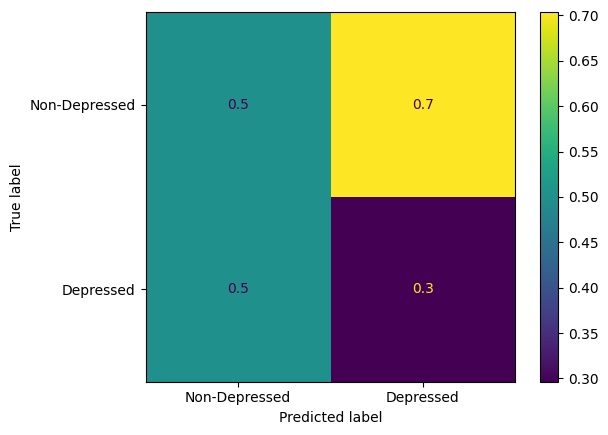

Accuracy = 0.39814814814814814
Recall = 0.37209302325581395
Precision = 0.2962962962962963
F1-score = 0.32989690721649484


In [371]:
#Predict
# x = norm_pose_train
# y = y_train
x = norm_pose_dev
y = y_dev
# x = x_dev_bad
# y = y_dev_bad
y_pose_prediction = model_pose.predict(x)
y_pose_prediction = np.argmax(y_pose_prediction, axis = 1)

# where_0 = np.where(y_pose_prediction == 0)
# where_1 = np.where(y_pose_prediction == 1)

# y_pose_prediction[where_0] = 1
# y_pose_prediction[where_1] = 0

# print(sum(y_pose_prediction)/len(y_pose_prediction))
print(y_pose_prediction)
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y, y_pose_prediction, normalize='pred')
print(result)
cm_display = ConfusionMatrixDisplay(confusion_matrix = result, display_labels = ["Non-Depressed", "Depressed"])
cm_display.plot()
plt.show()
tn_pose = result[0][0]
tp_pose = result[1][1]
fn_pose = result[1][0]
fp_pose = result[0][1]
accuracy = (tp_pose + tn_pose)/(tp_pose + tn_pose + fp_pose + fn_pose)
recall = tp_pose / (tp_pose + fn_pose)
precision = tp_pose / (tp_pose + fp_pose)
f1_score = 2 * precision * recall / (precision + recall)
print("Accuracy = " + str(accuracy))
print("Recall = " + str(recall))
print("Precision = " + str(precision))
print("F1-score = " + str(f1_score))

In [ ]:
model_pose.summary()

In [ ]:
plot_model(model_pose, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
# model_pose.save("saved_models/pose_12_7_C2")

INFO:tensorflow:Assets written to: saved_models/pose_12_7_C2\assets


INFO:tensorflow:Assets written to: saved_models/pose_12_7_C2\assets
